In [64]:
import random
import os
import copy
os.environ["OMP_NUM_THREADS"] = "1"
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import cv2
import warnings
import timeit
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import optim
from scipy.special import expit
from skimage import io, transform, measure
from sklearn import metrics
import optuna
from config import *
from util import *
from models import *
sns.set()
sns.set_style('white')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
rc = {"figure.figsize" : (9, 7),
      "axes.spines.left" : True,
      "axes.spines.right" : True,
      "axes.spines.bottom" : True,
      "axes.spines.top" : True,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True,
      "axes.grid" : True}
plt.rcParams.update(rc)

def confidence_interval(data, size=10000, func=np.mean):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    np.random.seed(42)
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return np.percentile(bs_replicates, [2.5, 97.5])

def accuracy_confidence_interval(data, size=10000, func=np.mean):
    bs_replicates = np.empty(size)
    
    np.random.seed(42)
    for i in range(size):
        bs_sample = data.sample(n=len(data), replace=True)
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = metrics.balanced_accuracy_score(bs_sample['benign_malignant'], bs_sample['prediction']).round(5)
    
    return np.percentile(bs_replicates, [2.5, 97.5])

def char_confidence_interval(data, char, size=10000, func=np.mean):
    bs_replicates = np.empty(size)
    
    np.random.seed(42)
    for i in range(size):
        bs_sample = data.sample(n=len(data), replace=True)
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = metrics.balanced_accuracy_score(bs_sample[char], bs_sample[char+'_pred']).round(5)
    
    return np.percentile(bs_replicates, [2.5, 97.5])

In [21]:
result_val = pd.read_csv(os.path.join("results", "combined_model", "result_val.csv"))
result_test = pd.read_csv(os.path.join("results", "combined_model", "result_test.csv"))
result_external = pd.read_csv(os.path.join("results", "combined_model", "result_external.csv"))
display_metrics(result_test)
print('Test:', accuracy_confidence_interval(result_test))
print()
display_metrics(result_external)
print('External:', accuracy_confidence_interval(result_external))

balanced acc:  0.86576
sensitivity:  0.832
specificity:  0.89952
Test: [0.825028   0.90322025]

balanced acc:  0.76886
sensitivity:  0.73469
specificity:  0.80303
External: [0.71583  0.820781]


In [40]:
char_acc = {}
cols = ['TRBL', 'BDG', 'GP', 'WLSA', 'PRL', 'PV', 'SPC', 'APC', 'OPC', 'MVP']
for col in cols:
    acc = metrics.balanced_accuracy_score(result_test[col], result_test[col+'_pred'])
    conf = char_confidence_interval(result_test, col)
    char_acc[col] = [acc, conf]

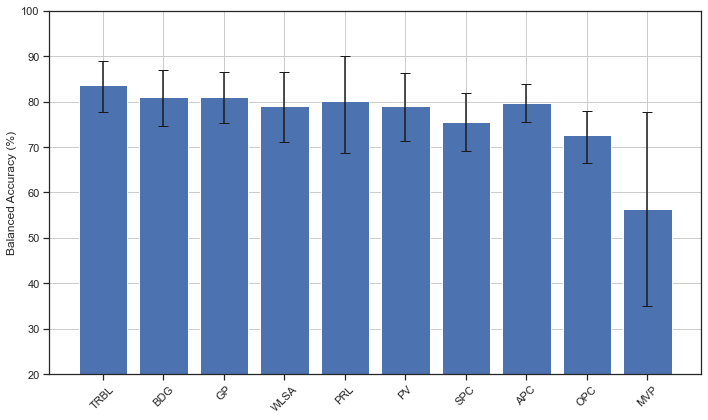

In [72]:
# Extracting keys, means, and confidence intervals
keys = list(char_acc.keys())
means = np.array([item[0] for item in char_acc.values()])*100
lower_bounds = np.array([item[1][0] for item in char_acc.values()])*100
upper_bounds = np.array([item[1][1] for item in char_acc.values()])*100

# Error bars
yerr = [means[i] - lower_bounds[i] for i in range(len(means))]

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(keys, means, yerr=[yerr, np.array(upper_bounds) - np.array(means)], capsize=5)
plt.ylabel('Balanced Accuracy (%)')
plt.title('')
plt.xticks(rotation=45)
plt.ylim(20, 100)
plt.tight_layout()
plt.savefig('suppl.png', dpi=300)

In [19]:
result_val = pd.read_csv(os.path.join("../vanilla_classifier", "results", "result_val.csv"))
result_test = pd.read_csv(os.path.join("../vanilla_classifier", "results", "result_test.csv"))
result_external = pd.read_csv(os.path.join("../vanilla_classifier", "results", "result_external.csv"))
display_metrics(result_test)
print('Test:', accuracy_confidence_interval(result_test))
print()
display_metrics(result_external)
print('External:', accuracy_confidence_interval(result_external))

balanced acc:  0.83619
sensitivity:  0.792
specificity:  0.88038
Test: [0.79340875 0.87706025]

balanced acc:  0.77134
sensitivity:  0.72449
specificity:  0.81818
External: [0.71812 0.82278]
